# Classification

Let's train models with the features we have extracted.

In [ ]:
import os
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from joblib import Parallel, delayed
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [53]:
def remove_low_data(feature_df, column_name="participant_id", threshold=0.2):
    """Remove participants with insufficient data.
    `feature_df` must contain 'participant_id'
    """
    participant_counts = feature_df.dropna()[column_name].value_counts()
    keep_threshold = participant_counts.max() * threshold
    keep_participants = list(participant_counts[participant_counts >= keep_threshold].index)
    feature_df = feature_df[feature_df[column_name].isin(keep_participants)].dropna()
    return feature_df

In [132]:
window_size = 30
step_size = 1

In [133]:
hololens_feature_df = pd.read_pickle(f"../data/working/hololens_feature_df_{window_size}-{step_size}.pkl")
print(hololens_feature_df.shape)
hololens_feature_df = remove_low_data(hololens_feature_df)
print(hololens_feature_df.shape)
hololens_feature_df.head()

(40066, 247)
(36501, 247)


,participant_id,session_id,cognitive_load,head_position_change_mean,head_position_change_std,head_position_change_median,head_position_change_mad,head_position_change_min,head_position_change_max,head_position_change_range,...,hand_strict_max_contralateral_distance_median,hand_strict_max_contralateral_distance_mad,hand_strict_max_contralateral_distance_min,hand_strict_max_contralateral_distance_max,hand_strict_max_contralateral_distance_range,hand_strict_max_contralateral_distance_iqr,hand_strict_max_contralateral_distance_skew,hand_strict_max_contralateral_distance_kurtosis,hand_strict_max_contralateral_distance_energy,hand_strict_max_contralateral_distance_rms
1742,3,2,0,0.002766,0.002707,0.001763,0.002104,0.000041,0.016895,0.016854,...,-0.133047,0.051065,-0.205151,0.202759,0.407910,0.103772,1.344565,2.187324,0.016399,0.128057
1743,3,2,0,0.002922,0.002718,0.001899,0.002143,0.000041,0.016895,0.016854,...,-0.136474,0.044570,-0.205096,0.202921,0.408017,0.031230,1.751704,4.143439,0.017625,0.132760
1744,3,2,0,0.003071,0.002722,0.002085,0.002159,0.000045,0.016895,0.016850,...,-0.135546,0.042973,-0.206018,0.203937,0.409955,0.029249,1.865121,4.839059,0.017712,0.133088
1745,3,2,0,0.003008,0.002666,0.002026,0.002098,0.000045,0.016895,0.016850,...,-0.134415,0.041772,-0.207248,0.205124,0.412372,0.028200,1.950713,5.419253,0.017685,0.132983
1746,3,2,0,0.003057,0.002656,0.002186,0.002090,0.000045,0.016895,0.016850,...,-0.134187,0.041700,-0.208310,0.206277,0.414586,0.027786,1.954339,5.531304,0.017497,0.132275


In [134]:
e4_feature_df = pd.read_pickle(f"../data/working/e4_feature_df_{window_size}-{step_size}.pkl") 
print(e4_feature_df.shape)
e4_feature_df = remove_low_data(e4_feature_df)
print(e4_feature_df.shape)
e4_feature_df.head()

(40066, 83)
(25634, 83)


,participant_id,session_id,cognitive_load,bvp_raw_mean,bvp_raw_std,bvp_raw_median,bvp_raw_mad,bvp_raw_min,bvp_raw_max,bvp_raw_range,...,temperature_raw_range,temperature_raw_iqr,temperature_raw_skew,temperature_raw_kurtosis,temperature_raw_energy,temperature_raw_rms,temperature_raw_max_freq,temperature_raw_mean_freq,temperature_raw_entropy,temperature_raw_psd
0,2,0,0,-2.136141,73.394602,-3.982177,56.194244,-230.6975,273.3171,504.0146,...,0.08,0.040,-0.356155,-0.414643,1082.936887,32.908006,0.008333,0.069719,2.706397,0.021003
1,2,0,0,-0.557511,72.573467,-3.534523,55.709491,-230.6975,273.3171,504.0146,...,0.08,0.025,-0.366038,-0.585770,1082.805247,32.906006,0.008333,0.065851,2.666918,0.025845
2,2,0,0,-1.273746,73.004364,-3.534523,56.166926,-230.6975,273.3171,504.0146,...,0.06,0.020,-0.413389,-0.826560,1082.673607,32.904006,0.008333,0.063048,2.637124,0.031030
3,2,0,0,0.632824,72.694216,-1.364120,55.530703,-230.6975,273.3171,504.0146,...,0.06,0.020,-0.328455,-0.834783,1082.585847,32.902672,0.008333,0.061667,2.630544,0.035785
4,2,0,0,1.654274,70.126952,-0.600952,53.766837,-230.6975,273.3171,504.0146,...,0.06,0.020,-0.241801,-0.858808,1082.520033,32.901672,0.008333,0.060922,2.649913,0.039985


In [61]:
combined_feature_df = pd.concat([hololens_feature_df, e4_feature_df.iloc[:, 3:]], axis=1).dropna()
combined_feature_df.shape

(24171, 327)

In [64]:
common_columns = list(combined_feature_df.columns[:3])

# only fixation features
column_subset = common_columns + [feature for feature in hololens_feature_df.columns if "fixation" in feature]
fixation_feature_df = hololens_feature_df[column_subset]

# only head features
column_subset = common_columns + [feature for feature in hololens_feature_df.columns if "head" in feature]
head_feature_df = hololens_feature_df[column_subset]

# all hand features
column_subset = common_columns + [feature for feature in hololens_feature_df.columns if "hand" in feature]
hand_feature_df = hololens_feature_df[column_subset]

# only combined hand features
column_subset = common_columns + [feature for feature in hand_feature_df.columns if "hand_max" in feature or "hand_strict" in feature]
combined_hand_feature_df = hand_feature_df[column_subset]

## Simple models

In [156]:
def train_model(feature_df):
    feature_df = feature_df.dropna()
    feature_columns = [feature for feature in feature_df.columns if feature not in ['participant_id', 'session_id', 'trial_id', 'cognitive_load']]
    X = feature_df[feature_columns]
    y = feature_df['cognitive_load']

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and train the logistic regression model
    model = LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000, penalty="l2")
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Evaluate the model
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    importance = np.abs(model.coef_[0]).round(3)
    feature_importance = pd.Series(importance, index=X.columns).sort_values(ascending=False)
    print("Feature Importance:")
    print(feature_importance[:13])

In [157]:
# combined hololens + e4 features
train_model(combined_feature_df)

Confusion Matrix:
[[2297   78]
 [  76 2384]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      2375
         1.0       0.97      0.97      0.97      2460

    accuracy                           0.97      4835
   macro avg       0.97      0.97      0.97      4835
weighted avg       0.97      0.97      0.97      4835

Feature Importance:
fixation_distance_skew                  5.265
fixation_distance_energy                5.057
head_up_angular_distance_iqr            4.060
head_position_change_mean               4.034
hand_max_contralateral_distance_mean    3.075
fixation_distance_std                   3.041
hand_max_position_change_iqr            2.959
head_up_angular_distance_median         2.838
head_forward_angular_distance_mad       2.491
bvp_raw_energy                          2.476
head_position_change_std                2.464
head_forward_angular_distance_mean      2.456
head_position_change_skew       

In [158]:
# all hololens features
train_model(hololens_feature_df)

Confusion Matrix:
[[3446  213]
 [ 229 3413]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3659
           1       0.94      0.94      0.94      3642

    accuracy                           0.94      7301
   macro avg       0.94      0.94      0.94      7301
weighted avg       0.94      0.94      0.94      7301

Feature Importance:
fixation_distance_energy                        6.158
hand_max_contralateral_distance_mean            5.288
fixation_distance_skew                          4.226
head_forward_angular_distance_mad               3.985
fixation_distance_rms                           3.638
hand_right_contralateral_distance_relu_rms      3.477
hand_max_contralateral_distance_rms             3.270
hand_left_contralateral_distance_relu_energy    2.729
head_position_change_mean                       2.718
hand_left_contralateral_distance_energy         2.691
head_up_angular_distance_iqr                

In [159]:
# all e4 features
train_model(e4_feature_df)

Confusion Matrix:
[[1868  611]
 [ 922 1726]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.75      0.71      2479
           1       0.74      0.65      0.69      2648

    accuracy                           0.70      5127
   macro avg       0.70      0.70      0.70      5127
weighted avg       0.71      0.70      0.70      5127

Feature Importance:
bvp_raw_mad               4.703
bvp_rri_rms               4.065
temperature_raw_energy    3.036
bvp_raw_energy            2.641
bvp_rri_mean              2.468
bvp_raw_iqr               2.205
bvp_rri_std               2.100
eda_phasic_mad            1.437
temperature_raw_std       1.305
eda_phasic_std            0.888
temperature_raw_range     0.851
eda_phasic_rms            0.696
temperature_raw_median    0.690
dtype: float64


In [160]:
# all hand features
train_model(hand_feature_df)

Confusion Matrix:
[[2993  666]
 [ 740 2902]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      3659
           1       0.81      0.80      0.80      3642

    accuracy                           0.81      7301
   macro avg       0.81      0.81      0.81      7301
weighted avg       0.81      0.81      0.81      7301

Feature Importance:
hand_max_contralateral_distance_mean             6.364
hand_right_contralateral_distance_energy         4.436
hand_right_contralateral_distance_relu_rms       4.223
hand_max_position_change_mad                     3.402
hand_max_contralateral_distance_rms              3.189
hand_right_position_change_mean                  3.143
hand_right_position_change_mad                   3.101
hand_left_contralateral_distance_energy          2.755
hand_max_contralateral_distance_std              2.480
hand_max_position_change_iqr                     2.389
hand_max_angular_distance_mean    

## Leave-one-out cross-validation

### Useful functions

#### Evaluation functions

In [137]:
def plot_confusion_matrix(true_values, predicted_values, labels=None, normalize=None, output_dir="output", suffix=""):
    """Evaluate the performance of a classifier"""

    mx = ConfusionMatrixDisplay.from_predictions(
        true_values,
        predicted_values,
        display_labels=labels,
        normalize="true" if normalize else None,
        include_values=False,
        colorbar=False,
    )
    
    # intercept chart to modify it
    ax = mx.ax_
    mx.plot(
        ax=ax,
        values_format=".0%" if normalize else ".0f",
        colorbar=False,
        cmap=plt.cm.Blues,
    )
    plt.ylabel("True class")
    plt.xlabel("Predicted class")
    plt.colorbar = None
    file_path = f"{output_dir}/confusion_matrix{suffix}.png"
    plt.savefig(file_path, bbox_inches="tight")

In [170]:
def process_results(
    results,
    output_path,
):
    importance_df = pd.DataFrame()
    true_values = []
    predicted_values = []
    scores = []
    
    for result in results:
        true_values.extend(result["y_test"])
        predicted_values.extend(result["predictions"])
        scores.append(result["score"])

        with open(f"{output_path}/scores.txt", "a") as f:
            f.write(f'{result["id_column"]}: {result["id_entity"]}; F1: {result["score"]:.3f}\n')

        with open(f"{output_path}/confusion_matrices.txt", "a") as f:
            f.write(f'{result["id_column"]}: {result["id_entity"]}\n')
            f.write(f'F1: {result["score"]:.3f}\n')
            f.write(f'{confusion_matrix(result["y_test"], result["predictions"])}\n\n')

        if not result["importances"].empty:
            importance_df = pd.concat([importance_df, result["importances"]], axis=1)
        
        # save models and scalers
        entity_str = f'{result["id_column"][:1]}{str(result["id_entity"]).zfill(2)}'
        with open(f'{output_path}/model_scaler_{entity_str}.pkl', "wb") as f:
            pickle.dump((result["model"], result["scaler"]), f)

    with open(f"{output_path}/scores.txt", "a") as f:
        f.write(f"\nMean F1: {np.mean(scores):.3f}\n")
        f.write(f"Standard deviation: {np.std(scores):.3f}\n")
        f.write(f"Min F1: {np.min(scores):.3f}\n")
        f.write(f"Max F1: {np.max(scores):.3f}\n")

    with open(f"{output_path}/confusion_matrices.txt", "a") as f:
        f.write(f"Final confusion matrix\n")
        f.write(
            f"F1: {f1_score(true_values, predicted_values, average='macro'):.3f}\n"
        )
        f.write(f"{confusion_matrix(true_values, predicted_values)}\n")

    if not importance_df.empty:
        importance_df_abs = importance_df.abs()
        importance_df.insert(0, "importance_mean", importance_df_abs.mean(axis=1).round(3))
        importance_df.insert(1, "importance_std", importance_df_abs.std(axis=1).round(3))
        importance_df = importance_df.sort_values(by="importance_mean", ascending=False)
        importance_df.to_csv(f"{output_path}/feature_importances.csv")

    model = results[0]["model"]
    with open(f"{output_path}/metadata.txt", "a") as f:
        f.write(f"Model name: {model.__class__.__name__}\n")
        f.write(f"Model parameters: {model.get_params()}\n")
        
    pd.DataFrame(
        {
            "true_values": true_values,
            "predicted_values": predicted_values,
        }
    ).to_pickle(f"{output_path}/model_df.pkl")

    print(f"Macro F1 score: {f1_score(true_values, predicted_values, average='macro'):.3f}")
    print(f"Accuracy: {accuracy_score(true_values, predicted_values):.3f}\n")

    return true_values, predicted_values, importance_df

#### Classification functions

In [171]:
def datasets_leaving_one_out(
    feature_label_df, id_column, leave_out_id, feature_columns, label_column_name
):
    train_df = feature_label_df[feature_label_df[id_column] != leave_out_id]
    test_df = feature_label_df[feature_label_df[id_column] == leave_out_id]
    X_train = train_df[feature_columns].values
    y_train = train_df[label_column_name].values
    X_test = test_df[feature_columns].values
    y_test = test_df[label_column_name].values

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, y_train, X_test, y_test, scaler


def train_model(
    feature_label_df,
    id_column,
    leave_out_id,
    feature_columns,
    label_column_name,
    classifier,
):
    X_train, y_train, X_test, y_test, scaler = datasets_leaving_one_out(
        feature_label_df, id_column, leave_out_id, feature_columns, label_column_name
    )

    if classifier == "svc":
        model = SVC(class_weight="balanced", probability=True, random_state=42)
    elif classifier == "logreg":
        model = LogisticRegression(class_weight="balanced", random_state=42)
    elif classifier == "rf":
        model = RandomForestClassifier(random_state=42, n_jobs=-1)
    else:
        raise ValueError("Invalid classifier.")

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    score = f1_score(y_test, predictions, average="macro")

    if classifier == "logreg":
        entity_str = f'{id_column[:1]}{str(int(leave_out_id)).zfill(2)}'
        importances = model.coef_[0].round(3)
        importance_df = pd.DataFrame(data=importances, index=feature_columns, columns=[entity_str])
    else:
        importance_df = pd.DataFrame()

    return {
        "id_column": id_column,
        "id_entity": leave_out_id,
        "feature_columns": feature_columns,
        "y_test": y_test,
        "predictions": predictions,
        "score": score,
        "importances": importance_df,
        "model": model,
        "scaler": scaler,
    }

In [174]:
def classify(
    dataset_name: str,
    label_column_name: str,
    feature_df: pd.DataFrame,
    classifier: str,
    validation: str,
    verbose: int = 11,
):
    """Train classifiers using leave-one-out cross validation, exporting results."""

    # setup
    if validation == "lopo":
        id_column = "participant_id"
    elif validation == "loto":
        id_column = "trial_id"
    elif validation == "loso":
        id_column = "session_id"
    else:
        raise ValueError("Wrong validation parameter.")
    datetime = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
    output_path = f"../data/output/{datetime}_{dataset_name}_{label_column_name}_{classifier}_{validation}"
    os.makedirs(output_path, exist_ok=True)
    with open(f"{output_path}/metadata.txt", "w") as f:
        f.write(f"Created at: {datetime}\n")
        f.write(f"Dataset: {dataset_name}\n")
        f.write(f"Label column: {label_column_name}\n")
        f.write(f"Validation: {validation}\n")
        f.write(f"Sliding window: {window_size}-{step_size}\n")

    feature_columns = list(feature_df.columns[3:])
    feature_df = feature_df.dropna().reset_index(drop=True)
    entity_ids = list(
        feature_df[id_column].unique()
    )  # e.g. [1, ..., 16] for 16 participants or [1, ..., 33] for 33 documents
    
    # train
    results = Parallel(
        n_jobs=-1, verbose=verbose  # verbose > 10, all iterations are reported
    )(
        delayed(train_model)(
            feature_df,
            id_column,
            entity_id,
            feature_columns,
            label_column_name,
            classifier,
        )
        for entity_id in entity_ids
    )
    time.sleep(0.1)  # wait for the last iteration to finish

    true_values, predicted_values, importance_df = process_results(
        results,
        output_path,
    )
    id_columns = feature_df.columns[:3]
    results_df = pd.concat(
        [
            feature_df[id_columns],
            pd.Series(true_values, name="true_values"),
            pd.Series(predicted_values, name="predicted_values"),
        ],
        axis=1
    )
    
    return {
        "results_df": results_df,
        "true_values": true_values,
        "predicted_values": predicted_values,
        "importance_df": importance_df,
        "output_path": output_path,
    }

### Run classifiers

In [168]:
# constants
label_column_name = "cognitive_load"
validation = "lopo"

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    6.6s remaining:   49.9s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    6.6s remaining:   21.8s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    6.7s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    6.7s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    6.8s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    6.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    6.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    6.9s finished


Macro F1 score: 0.754
Accuracy: 0.754



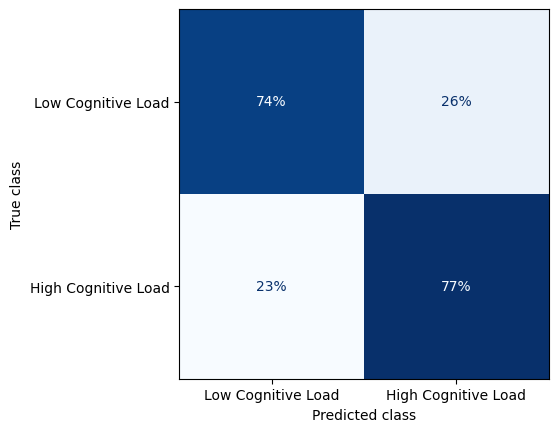

In [175]:
dataset_name = "combined_data"
classifier = "logreg"

results = classify(
    dataset_name,
    label_column_name,
    combined_feature_df,
    classifier,
    validation
)

plot_confusion_matrix(
    results["true_values"],
    results["predicted_values"],
    ["Low Cognitive Load", "High Cognitive Load"], 
    normalize=True,
    output_dir=results["output_path"],
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done   2 out of  21 | elapsed:    8.0s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   4 out of  21 | elapsed:    8.2s remaining:   35.1s
[Parallel(n_jobs=-1)]: Done   6 out of  21 | elapsed:    8.3s remaining:   20.8s
[Parallel(n_jobs=-1)]: Done   8 out of  21 | elapsed:    8.4s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done  10 out of  21 | elapsed:    8.5s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done  12 out of  21 | elapsed:    8.5s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done  14 out of  21 | elapsed:    8.6s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    8.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  18 out of  21 | elapsed:    8.7s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   10.1s finished


Macro F1 score: 0.840
Accuracy: 0.840



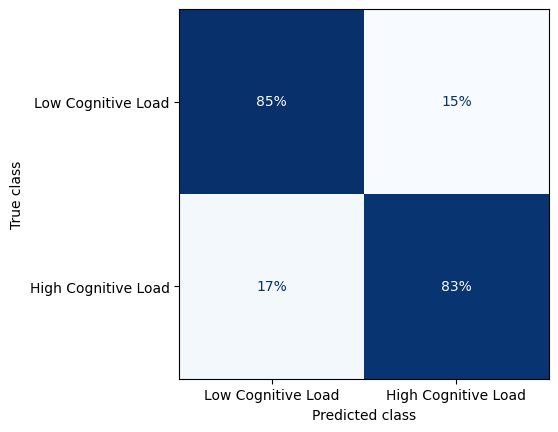

In [176]:
dataset_name = "hololens"
classifier = "logreg"

results = classify(
    dataset_name,
    label_column_name,
    hololens_feature_df,
    classifier,
    validation
)

plot_confusion_matrix(
    results["true_values"],
    results["predicted_values"],
    ["Low Cognitive Load", "High Cognitive Load"], 
    normalize=True,
    output_dir=results["output_path"],
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:    1.9s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done   5 out of  18 | elapsed:    1.9s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    2.0s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   9 out of  18 | elapsed:    2.0s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    2.1s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    2.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    2.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    2.1s finished


Macro F1 score: 0.552
Accuracy: 0.554



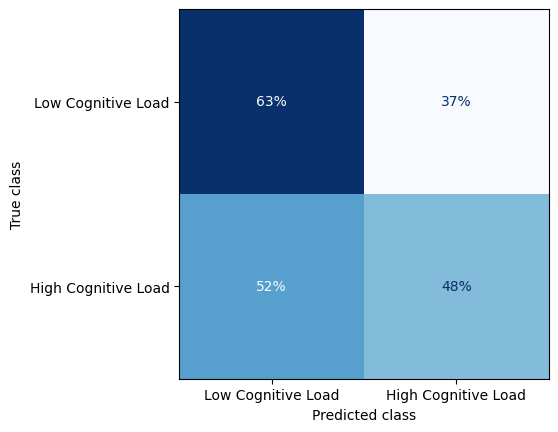

In [177]:
dataset_name = "e4"
classifier = "logreg"

results = classify(
    dataset_name,
    label_column_name,
    e4_feature_df,
    classifier,
    validation
)

plot_confusion_matrix(
    results["true_values"],
    results["predicted_values"],
    ["Low Cognitive Load", "High Cognitive Load"], 
    normalize=True,
    output_dir=results["output_path"],
)